# IMPRT L|B

In [1]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

# D4T4

In [2]:
df = pd.read_csv('C:/Users/i7/Documents/Git/D4T4/FIRE/timeseries/data/Month_Reg_CO.txt', 
                 header=1).drop(columns='area')
df.columns = df.columns.str.replace(' ', '')
df.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,2003,13,12,92,66,44,13,255,29,92,89,12,7.0
1,2004,10,7,180,75,87,73,65,32,84,29,9,26.0
2,2005,11,43,107,95,122,30,172,30,54,41,43,20.0
3,2006,45,54,75,153,46,110,47,5,24,9,48,4.0
4,2007,6,4,58,89,59,60,30,26,75,121,100,17.0


# M3L_|_

In [3]:
df_m = pd.melt (df, id_vars=['year'], value_vars=df.columns[1:], 
                var_name='month')
df_m['date'] = df_m['year'].astype(str)+'-'+df_m['month']+'-01'

In [4]:
df_m.head()

,year,month,value,date
0,2003,jan,13.0,2003-jan-01
1,2004,jan,10.0,2004-jan-01
2,2005,jan,11.0,2005-jan-01
3,2006,jan,45.0,2006-jan-01
4,2007,jan,6.0,2007-jan-01


In [5]:
df_i = (df_m.set_index(pd.to_datetime(df_m['date']))
.drop(columns=['year', 'month', 'date'])
.sort_index())

In [6]:
df_i.head()

,value
date,
2003-01-01,13.0
2003-02-01,12.0
2003-03-01,92.0
2003-04-01,66.0
2003-05-01,44.0


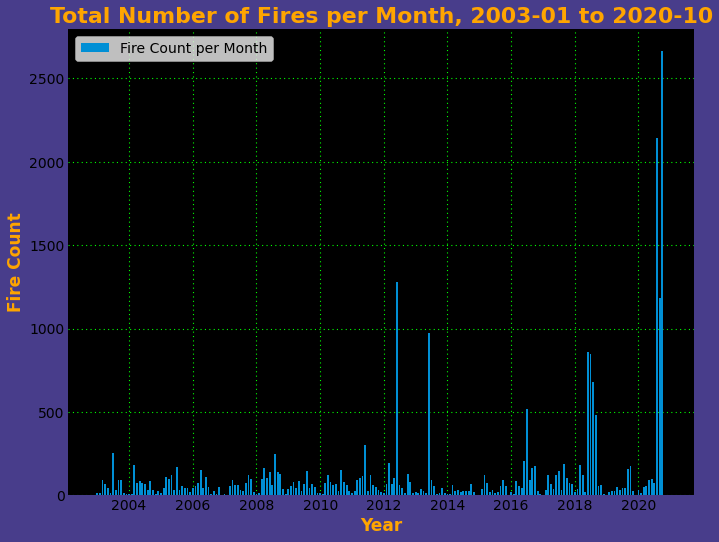

In [7]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 8))

fig.set_facecolor('darkslateblue')
ax.set_facecolor('black')

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.bar(df_i.index, df_i['value'], width=20, label='Fire Count per Month')

ax.set_title("Total Number of Fires per Month, 2003-01 to 2020-10", color='orange',
            fontsize=(22), fontweight='bold')
ax.set_xlabel('Year', color='orange', fontsize=(17), fontweight='bold')
ax.set_ylabel('Fire Count', color='orange', fontsize=(17), fontweight='bold')

ax.grid(b=True, color='lime', linestyle=(0, (1, 3)), linewidth=1.1)
ax.legend()

plt.show()

# NGNR
## Months before
 - Engineered features that take into account the previous month and the month before that to predict fire count in the next month.

In [8]:
df_i['target'] = df_i.shift(-1)
df_i['1_mo_prev'] = df_i['value'].shift(1)
df_i['2_mo_prev'] = df_i['1_mo_prev'].shift(1)
df_i['month'] = df_i.index.month

In [9]:
df_I = df_i[['month', 'target', 'value', '1_mo_prev', '2_mo_prev']].dropna()

In [10]:
target = 'target'
y = df_I['target']
X = df_I.drop(columns=target)

In [11]:
print(len(X) * 0.8)
print(len(X) * 0.9)

169.60000000000002
190.8


In [12]:
cutV = 170
cutT = 191
X_train, y_train = X.iloc[:cutV], y.iloc[:cutV]
X_val, y_val = X.iloc[cutV : cutT], y.iloc[cutV : cutT]
X_test, y_test = X.iloc[cutT:], y.iloc[cutT:]

assert len(X_train) + len(X_val) + len(X_test) == len(X)

# B4SL|N

In [13]:
y_t_mean = y_train.mean()
print(y_t_mean)

75.31176470588235


In [14]:
y_pred = [y_t_mean] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 59.122491349480974


# Models

In [15]:
model_boo = XGBRegressor(random_state=17) # default n_estimators=100
model_boo.fit(X_train, y_train)

model_rf = RandomForestRegressor(random_state=23) #n_estimators=100
model_rf.fit(X_train, y_train)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train);

In [16]:
for model in [model_boo, model_rf, model_lr]:
    print(type(model))
    print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
    print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
    print()

<class 'xgboost.sklearn.XGBRegressor'>
Training MAE: 0.08360541427836699
Validation MAE: 153.95223488126481

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Training MAE: 21.309470588235296
Validation MAE: 141.73809523809527

<class 'sklearn.linear_model._base.LinearRegression'>
Training MAE: 56.25341139808951
Validation MAE: 154.97116072652418



In [17]:
params = {
    'max_depth' : range(10, 510, 100),
    'n_estimators' : range(10, 310, 50),
    'max_samples' : np.arange(0, 1, 0.1)}

In [18]:
pipeline = RandomForestRegressor(random_state=19,
                                n_jobs=-1)

model_search = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_iter=20,
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [19]:
model_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=19),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': range(10, 510, 100),
                                        'max_samples': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'n_estimators': range(10, 310, 50)},
                   verbose=1)

In [20]:
# Mean cross-validated score of the best_estimator.
model_search.best_score_

-0.16453226525110615

In [21]:
# Parameter setting that gave the best results on the hold out data.
model_search.best_params_

{'n_estimators': 210, 'max_samples': 0.1, 'max_depth': 410}

In [22]:
model_rf = RandomForestRegressor(random_state=23,
                                n_estimators=16,
                                max_samples=0.1,
                                max_depth=410) #n_estimators=100
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=410, max_samples=0.1, n_estimators=16,
                      random_state=23)

In [23]:
model_rf.predict(X_val)

array([ 54.4375,  56.6875,  57.1875,  88.8125,  84.0625,  86.0625,
       139.9375,  35.1875,  74.5   ,  51.5625, 127.9375,  83.125 ,
       229.75  , 105.1875, 124.4375, 195.1875, 203.0625, 177.1875,
       143.6875,  90.9375,  72.75  ])

In [24]:
mean_absolute_error(y_val, model.predict(X_val))

154.97116072652418

In [25]:
model_rf.predict(X_test)

array([ 77.8125,  59.8125,  46.75  ,  53.375 ,  41.75  ,  42.1875,
        39.5   ,  62.75  , 121.1875,  69.625 , 173.8125,  50.5   ,
       149.375 ,  52.6875,  62.9375,  59.75  ,  61.9375,  50.75  ,
        76.375 , 122.75  , 203.125 ])

In [26]:
mean_absolute_error(y_test, model.predict(X_test))

316.77434401363155

# NGNR
## 1 Year

In [27]:
df_i = (df_m.set_index(pd.to_datetime(df_m['date']))
.drop(columns=['year', 'month', 'date'])
.sort_index())

In [28]:
df_i['target'] = df_i.shift(-1)
df_i['12_mo_prev'] = df_i['value'].shift(12)
df_i['month'] = df_i.index.month

In [29]:
df_I = df_i[['month', 'target', 'value', '12_mo_prev']].dropna()

In [30]:
target = 'target'
y = df_I['target']
X = df_I.drop(columns=target)

In [31]:
print(len(X) * 0.8)
print(len(X) * 0.9)

161.60000000000002
181.8


In [32]:
cutV = 162
cutT = 182
X_train, y_train = X.iloc[:cutV], y.iloc[:cutV]
X_val, y_val = X.iloc[cutV : cutT], y.iloc[cutV : cutT]
X_test, y_test = X.iloc[cutT:], y.iloc[cutT:]

assert len(X_train) + len(X_val) + len(X_test) == len(X)

# B4SL|N

In [33]:
y_t_mean = y_train.mean()
print(y_t_mean)

76.84567901234568


In [34]:
y_pred = [y_t_mean] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 59.908169486358794


# Models

In [35]:
model_boo = XGBRegressor(random_state=17) # default n_estimators=100
model_boo.fit(X_train, y_train)

model_rf = RandomForestRegressor(random_state=23) #n_estimators=100
model_rf.fit(X_train, y_train)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train);

In [36]:
for model in [model_boo, model_rf, model_lr]:
    print(type(model))
    print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
    print('Val MAE:', mean_absolute_error(y_val, model.predict(X_val)))
    print()

<class 'xgboost.sklearn.XGBRegressor'>
Training MAE: 0.11309710402547578
Val MAE: 160.2012669146061

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Training MAE: 22.581419753086422
Val MAE: 131.88449999999997

<class 'sklearn.linear_model._base.LinearRegression'>
Training MAE: 56.809381505441884
Val MAE: 160.52547645252127



In [37]:
params = {
    'max_depth' : range(10, 510, 100),
    'n_estimators' : range(10, 310, 50),
    'max_samples' : np.arange(0, 1, 0.1)}

In [38]:
pipeline = RandomForestRegressor(random_state=19,
                                n_jobs=-1)

model_search = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_iter=20,
    n_jobs=-1,
    cv=5,
    verbose=1
)

In [39]:
model_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=19),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': range(10, 510, 100),
                                        'max_samples': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'n_estimators': range(10, 310, 50)},
                   verbose=1)

In [40]:
model_search.best_score_

-0.3654150072771258

In [41]:
best = model_search.best_params_
best

{'n_estimators': 210, 'max_samples': 0.30000000000000004, 'max_depth': 310}

In [42]:
model_rf = RandomForestRegressor(random_state=23,
                                n_estimators=210,
                                max_samples=0.1,
                                max_depth=110) #n_estimators=100
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=110, max_samples=0.1, n_estimators=210,
                      random_state=23)

In [43]:
model_rf.predict(X_val)

array([106.84285714,  53.92857143, 146.45714286, 137.93809524,
        53.25238095,  46.77619048,  64.31904762,  72.23809524,
       190.56666667, 114.20952381,  62.06666667, 195.55238095,
       166.47142857, 136.78095238, 143.15714286,  84.46666667,
        42.98095238,  36.54285714,  65.91904762,  64.32380952])

In [44]:
mean_absolute_error(y_val, model.predict(X_val))

160.52547645252127

In [45]:
model_rf.predict(X_test)

array([133.92380952, 167.64285714,  74.3047619 , 111.83809524,
        95.59047619,  94.13809524, 108.68095238,  96.46666667,
        30.04761905,  32.01428571,  71.31428571,  72.60952381,
        76.23809524,  71.4       ,  92.49047619, 104.18095238,
        75.04761905, 127.81904762, 159.13809524, 146.24285714])

In [46]:
mean_absolute_error(y_test, model.predict(X_test))

326.0508788074434

# NGNR
## 2 year

In [47]:
df_i['target'] = df_i.shift(-1)
df_i['12_mo_prev'] = df_i['value'].shift(12)
df_i['24_mo_prev'] = df_i['12_mo_prev'].shift(12)
df_i['month'] = df_i.index.month

In [48]:
df_I = df_i[['month', 'target', 'value', '12_mo_prev', '24_mo_prev']].dropna()

# SPL|T

In [49]:
target = 'target'
y = df_I['target']
X = df_I.drop(columns=target)

In [50]:
print(len(X) * 0.8)
print(len(X) * 0.9)

152.0
171.0


In [51]:
cutV = 152
cutT = 171
X_train, y_train = X.iloc[:cutV], y.iloc[:cutV]
X_val, y_val = X.iloc[cutV : cutT], y.iloc[cutV : cutT]
X_test, y_test = X.iloc[cutT:], y.iloc[cutT:]

assert len(X_train) + len(X_val) + len(X_test) == len(X)

# B4SL|N

In [52]:
y_t_mean = y_train.mean()
print(y_t_mean)

78.85526315789474


In [53]:
y_pred = [y_t_mean] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Baseline MAE: 62.480436288088654


# Models

In [54]:
model_boo = XGBRegressor(random_state=17) # default n_estimators=100
model_boo.fit(X_train, y_train)

model_rf = RandomForestRegressor(random_state=23) #n_estimators=100
model_rf.fit(X_train, y_train)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train);

In [55]:
for model in [model_boo, model_rf, model_lr]:
    print(type(model))
    print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
    print('Val MAE:', mean_absolute_error(y_val, model.predict(X_val)))
    print()

<class 'xgboost.sklearn.XGBRegressor'>
Training MAE: 0.021704466719376415
Val MAE: 174.2873542622516

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Training MAE: 22.734013157894736
Val MAE: 147.4215789473684

<class 'sklearn.linear_model._base.LinearRegression'>
Training MAE: 59.68743798765177
Val MAE: 164.77862559072557



In [56]:
params = {
    'max_depth' : range(380, 450, 5),
    'n_estimators' : range(140, 200, 5),
    'max_samples' : np.arange(0, 0.5, 0.15)}

In [57]:
pipeline = RandomForestRegressor(random_state=19,
                                n_jobs=-1)

model_search = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_iter=20,
    n_jobs=-1,
    cv=30,
    verbose=1
)

In [58]:
model_search.fit(X_train, y_train)

Fitting 30 folds for each of 20 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   27.1s finished


RandomizedSearchCV(cv=30,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=19),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': range(380, 450, 5),
                                        'max_samples': array([0.  , 0.15, 0.3 , 0.45]),
                                        'n_estimators': range(140, 200, 5)},
                   verbose=1)

In [59]:
model_search.best_score_

-2.308035596885973

In [60]:
best = model_search.best_params_
best

{'n_estimators': 175, 'max_samples': 0.3, 'max_depth': 420}

In [61]:
model_rf = RandomForestRegressor(random_state=5,
                                n_estimators=160,
                                max_samples=0.15,
                                max_depth=420) #n_estimators=100
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=420, max_samples=0.15, n_estimators=160,
                      random_state=5)

In [62]:
model_rf.predict(X_val)

array([110.03125, 165.31875,  58.35625,  64.05   ,  51.5125 ,  75.30625,
       184.49375,  92.2875 ,  55.35625, 172.8125 , 159.33125, 131.25   ,
       164.68125,  92.7875 ,  48.75625,  46.45   ,  45.6375 ,  53.325  ,
       147.63125])

In [63]:
mean_absolute_error(y_val, model.predict(X_val))

164.77862559072557

In [64]:
model_rf.predict(X_test)

array([ 98.6875 ,  69.59375, 131.7625 , 104.65   ,  64.44375, 141.975  ,
       112.16875,  40.3875 ,  33.6    ,  68.00625,  51.825  ,  74.525  ,
        88.06875, 103.8    , 137.4125 ,  84.7875 , 117.7375 , 156.10625,
       103.8    ])

In [65]:
mean_absolute_error(y_test, model.predict(X_test))

342.4653138560925